Train Data Sample:
   id                                  heartbeat_signals  label
0   0  0.9912297987616655,0.9435330436439665,0.764677...    0.0
1   1  0.9714822034884503,0.9289687459588268,0.572932...    0.0
2   2  1.0,0.9591487564065292,0.7013782792997189,0.23...    2.0
3   3  0.9757952826275774,0.9340884687738161,0.659636...    0.0
4   4  0.0,0.055816398940721094,0.26129357194994196,0...    2.0
Test Data Sample:
       id                                  heartbeat_signals
0  100000  0.9915713654170097,1.0,0.6318163407681274,0.13...
1  100001  0.6075533139615096,0.5417083883163654,0.340694...
2  100002  0.9752726292239277,0.6710965234906665,0.686758...
3  100003  0.9956348033996116,0.9170249621481004,0.521096...
4  100004  1.0,0.8879490481178918,0.745564725322326,0.531...
Reshaped Test features shape: (20000, 205, 1), dtype: float16
After SMOTE, Resampled training features shape: (257308, 205), Resampled training labels shape: (257308,)


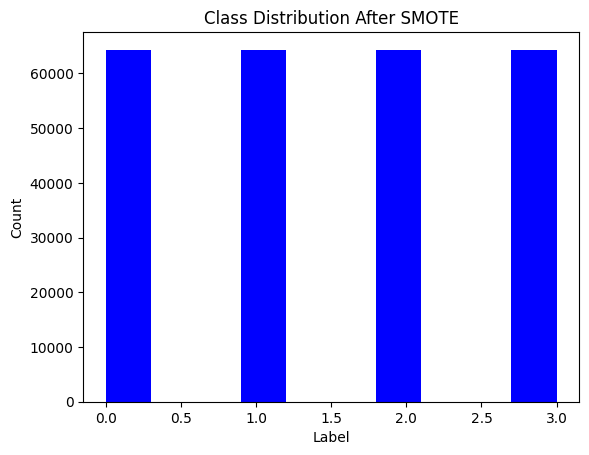

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
3217/3217 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.8854 - loss: 1.4390 - val_accuracy: 0.9360 - val_loss: 0.5120 - learning_rate: 0.0010
Epoch 2/50
3217/3217 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9448 - loss: 0.4703 - val_accuracy: 0.9828 - val_loss: 0.3027 - learning_rate: 0.0010
Epoch 3/50
3217/3217 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9499 - loss: 0.4027 - val_accuracy: 0.9739 - val_loss: 0.3156 - learning_rate: 0.0010
Epoch 4/50
3217/3217 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9512 - loss: 0.3796 - val_accuracy: 0.9828 - val_loss: 0.2672 - learning_rate: 0.0010
Epoch 5/50
3217/3217 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9542 - loss: 0.3555 - val_accuracy: 0.9691 - val_loss: 0.3107 - learning_rate: 0.0010
Epoch 6/50
3217/3217 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9540 - loss: 0.3463 - val_accuracy: 0.9702 - val_loss: 0.2921 - learning_rate: 0.0010
Epoch 7/50
3217/3217 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9

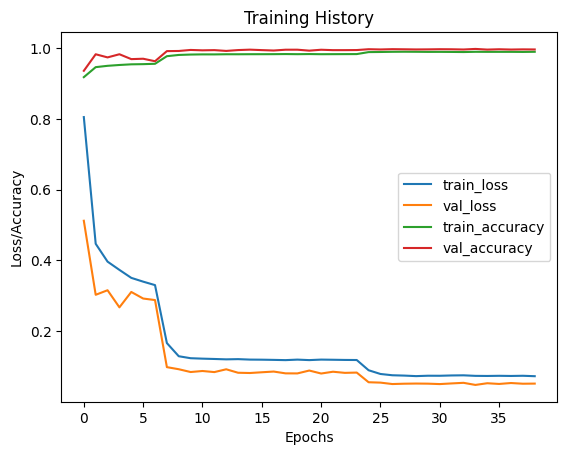

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
       id       label_0       label_1       label_2       label_3
0  100000  9.999994e-01  3.837041e-07  2.596211e-08  1.935031e-07
1  100001  1.166604e-07  2.165562e-07  9.999956e-01  4.128844e-06
2  100002  1.563583e-07  1.182170e-08  2.879023e-07  9.999995e-01
3  100003  9.999961e-01  1.155297e-07  3.472082e-06  3.530436e-07
4  100004  9.999716e-01  2.828088e-11  2.286056e-08  2.840165e-05


In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential, layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

# 定义文件路径
train_path = '/kaggle/input/heartpicture/train.csv'
test_path = '/kaggle/input/heartpicture/testA.csv'

def load_and_preprocess_train_data(filepath):
    """
    Load and preprocess the training data from a CSV file.
    
    Parameters:
        filepath (str): Path to the CSV file.
        
    Returns:
        pd.DataFrame: Processed DataFrame with reduced memory usage.
    """
    # Load the data
    df = pd.read_csv(filepath)
    
    # Check if required columns are present
    required_columns = ['id', 'heartbeat_signals', 'label']
    if not all(column in df.columns for column in required_columns):
        raise ValueError(f"Missing columns in train data: {required_columns}")
    
    # Display the first few rows of the dataframe
    print("Train Data Sample:")
    print(df.head())
    
    # Split heartbeat_signals into separate columns
    signal_columns = df['heartbeat_signals'].str.split(',', expand=True).astype(float)
    df = pd.concat([df[['id', 'label']], signal_columns], axis=1)
    
    # Rename columns
    df.columns = ['id', 'label'] + [f's_{i}' for i in range(signal_columns.shape[1])]
    
    # Reduce memory usage
    df = reduce_mem_usage(df)
    
    return df

def load_and_preprocess_test_data(filepath):
    """
    Load and preprocess the test data from a CSV file.
    
    Parameters:
        filepath (str): Path to the CSV file.
        
    Returns:
        pd.DataFrame: Processed DataFrame with reduced memory usage.
    """
    # Load the data
    df = pd.read_csv(filepath)
    
    # Check if required columns are present
    required_columns = ['id']
    if not all(column in df.columns for column in required_columns):
        raise ValueError(f"Missing columns in test data: {required_columns}")
    
    # Display the first few rows of the dataframe
    print("Test Data Sample:")
    print(df.head())
    
    # Drop label columns since they are not needed for prediction
    if 'label_0' in df.columns:
        df = df.drop(columns=['label_0', 'label_1', 'label_2', 'label_3'])
    
    # Split heartbeat_signals into separate columns
    signal_columns = df['heartbeat_signals'].str.split(',', expand=True).astype(float)
    df = pd.concat([df[['id']], signal_columns], axis=1)
    
    # Rename columns
    df.columns = ['id'] + [f's_{i}' for i in range(signal_columns.shape[1])]
    
    # Reduce memory usage
    df = reduce_mem_usage(df)
    
    return df

def reduce_mem_usage(df):
    """
    Reduce memory usage of a DataFrame by converting column types.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame.
        
    Returns:
        pd.DataFrame: DataFrame with reduced memory usage.
    """
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    return df

# 数据加载与预处理
try:
    train = load_and_preprocess_train_data(train_path)
    test = load_and_preprocess_test_data(test_path)
except FileNotFoundError as e:
    print(f"Error: {e}")
    raise
except ValueError as e:
    print(f"Value Error: {e}")
    raise

# 查看训练集, 分离标签与样本, 去除 id
y_train = train['label']
x_train = train.drop(['id', 'label'], axis=1)

# 标准化特征
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
X_test_scaled = scaler.transform(test.drop(['id'], axis=1))

# 将测试集转换为适应 CNN 输入的 shape
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)
print(f"Reshaped Test features shape: {X_test_scaled.shape}, dtype: {X_test_scaled.dtype}")

# 使用 SMOTE 对数据进行上采样以解决类别不平衡问题
smote = SMOTE(random_state=2021)
k_x_train, k_y_train = smote.fit_resample(x_train_scaled, y_train)  
print(f"After SMOTE, Resampled training features shape: {k_x_train.shape}, Resampled training labels shape: {k_y_train.shape}")

# 将训练集转换为适应 CNN 输入的 shape
k_x_train = k_x_train.reshape(k_x_train.shape[0], k_x_train.shape[1], 1)

# 查看类别分布
plt.hist(k_y_train, orientation='vertical', histtype='bar', color='blue')
plt.title('Class Distribution After SMOTE')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# 定义改进后的CNN模型
model = Sequential([
    layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(k_x_train.shape[1], 1), 
                  kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(filters=128, kernel_size=3, activation='relu', 
                  kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])

# 编译模型
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 回调函数
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# 训练模型
history = model.fit(k_x_train, k_y_train, epochs=50, batch_size=64, validation_split=0.2, 
                    callbacks=[early_stopping, reduce_lr])

# 绘制训练过程
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.show()

# 进行预测
predictions = model.predict(X_test_scaled)
predicted_labels = np.argmax(predictions, axis=1)

# 提交格式化
submission_df = pd.DataFrame({
    'id': test['id'],
    'label_0': predictions[:, 0],
    'label_1': predictions[:, 1],
    'label_2': predictions[:, 2],
    'label_3': predictions[:, 3]
})

# 保存提交文件
submission_df.to_csv('submission.csv', index=False)
print(submission_df.head())



